In [1]:
!pip install matplotlib
!pip install networkx
!pip install tsplib95
!pip install vrplib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import tsplib95
import itertools as it
import random
import vrplib
import math
from operator import attrgetter

In [46]:
def draw_graph(G):
    pos = nx.circular_layout(G)
    
    nx.draw_networkx_nodes(G, pos,
                           nodelist=[n for n, attr in G.nodes(data=True)],
                           node_color='lightgreen',
                           node_size=300)
    
    nx.draw_networkx_labels(G, pos, font_size=10)
    nx.draw_networkx_edges(G, pos, edge_color='gray')
    
    labels = nx.get_edge_attributes(G,'distância')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    plt.axis('off')
    plt.title("Exemplo grafo")
    plt.show()

def draw_graph2(G):
    pos = {i: (data['x'], data['y']) for i, data in G.nodes(data=True)}
    plt.figure(figsize=(8, 6))    
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue')
    nx.draw_networkx_edges(G, pos)
    labels = {i: f'{i} (d={data["demand"]})' for i, data in G.nodes(data=True)}
    nx.draw_networkx_labels(G, pos, labels, font_size=10)
    plt.title("Gráfico de nodos VRP (Vehicle Routing Problem)")
    plt.xlabel("Coordenada X")
    plt.ylabel("Coordenada Y")
    plt.grid(True)
    plt.show()


[0, 1]


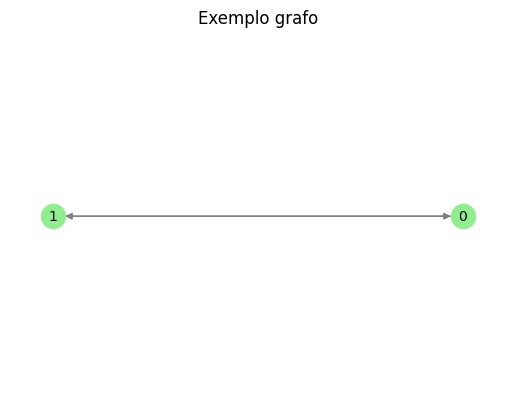

OutMultiEdgeDataView([(0, 1, {'weight': 10}), (1, 0, {'weight': 15})])

In [4]:
# Dados do problema
vertices = [0, 1]
print(vertices)

# Adicionar vértices com atributos
G = nx.MultiDiGraph()  # Grafo direcionado
for i in vertices:
    G.add_node(i)

# Adicionar arestas com atributo de distância
arestas = [
    (0, 1, {"distância": 10}),
    (1, 0, {"distância": 15}),

]
for aresta in arestas:
    G.add_edge(aresta[0], aresta[1], weight=aresta[2]['distância'])
# G.add_edges_from([(e[0], e[1], dict(e[2])) for e in arestas])
# nx.set_edge_attributes(G, {(u, v): d for u, v, d in arestas})
# draw_labeled_multigraph(G, "distância")
# draw_graph(G)

draw_graph(G)
G.edges(data=True)

## CLASSES

In [5]:
# Função para calcular a distância entre dois nós
def euclidean_distance(node1, node2):
    x1, y1 = G.nodes[node1]['x'], G.nodes[node1]['y']
    x2, y2 = G.nodes[node2]['x'], G.nodes[node2]['y']
    
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def calculate_path_qualitity(G, path):
    qualitity = 0
    for i in range(len(path) - 1):
        node = path[i]
        next_node = path[i + 1]
        qualitity += euclidean_distance(node, next_node)
    # Soma do último cliente visitado para voltar ao depósito
    # qualitity += G[len(path) - 1][0][0]['weight']
    return qualitity

def calculate_demand_path(G, path):
    capacity = 0
    for node in path:
        capacity += G.nodes[node]['demand']
    return capacity

    
def get_best_team_qualitity(teams):
    best_team = None
    for team in teams:
        if best_team == None:
            best_team = team
        elif team.qualitity < best_team.qualitity:
            best_team = team
    return best_team

class Player:
    def __init__(self):
        self.path = []
        self.capacity = 0
        self.qualitity = 0

    def set_path(self, path):
        self.path = path
        
    def calculate_qualitity(self, G):
        self.qualitity = calculate_path_qualitity(G, self.path)
        return self.qualitity
        
class Team:
    def __init__(self):
        self.players = []
        self.captain = None
        self.qualitity = 0
        self.points = 0

    def add_player(self, player):
        self.players.append(player)

    def set_captain(self, player):
        self.captain = player

    def calculate_qualitity(self, G):
        self.qualitity = 0
        for index, player in enumerate(self.players):
            player_qualitity = player.calculate_qualitity(G)
            self.qualitity += player_qualitity
            if index == 0:
                self.captain = player
            elif player_qualitity < self.captain.qualitity:
                self.captain = player
        return self.qualitity

class Table:
    def __init__(self, teams):
        self.teams = teams

    def match(self, team_a, team_b):
        if team_a.qualitity < team_b.qualitity:
            team_a.points += 3
        elif team_b.qualitity < team_a.qualitity:
            team_b.points += 3
        else:
            team_a.points += 1
            team_b.points += 1
    
    def reset(self):
        for team in self.teams:
            team.points = 0

https://link.springer.com/article/10.1007/s10489-013-0512-y
<br>Formato padrão files: http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp95.pdf

## Inicialização do grafo

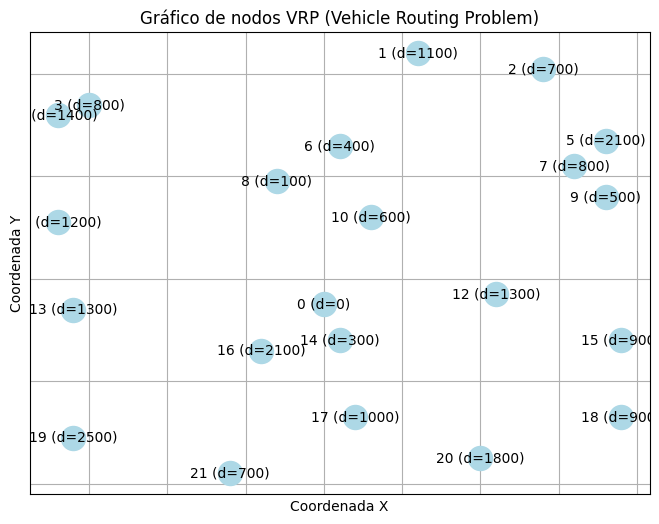

In [48]:
G = nx.MultiDiGraph()

instance = vrplib.read_instance("./Vrp-Set-E/E/E-n22-k4.vrp")
demand = instance['demand']
nodes_coords = instance['node_coord']
for i, (x, y) in enumerate(nodes_coords):
    G.add_node(i, x=int(x), y=int(y), demand=int(demand[i]))

G.edges(data=True)
draw_graph2(G)

## Fase de Inicialização
Trabalho com técnica: https://ieeexplore.ieee.org/document/7550764
<br>
The first step is the creation of a set of solutions, called P,
which will make up the initial population. All solutions are
created randomly and they are called player (pi).

In [64]:
vehicle_capacity = 6000
players_quantity = 10
teams_quantity = 16

# Inicialização e divisão dos jogadores em times
teams = []
for i in range(0, teams_quantity):
    team = Team()
    teams.append(team)
    nodes_available = list(G)
    nodes_available.pop(0) # Remoção do nodo depósito
    for j in range(0, players_quantity):
        if (len(nodes_available) == 0):
            break
        player = Player()
        team.add_player(player)
        path = [0]
        while player.capacity < vehicle_capacity:
            node = random.choice(nodes_available)
            nodes_available.remove(node)
            path.append(node)
            player.capacity += G.nodes[node]['demand']
            if (len(nodes_available) == 0):
                break
        path.append(0)
        player.path = path

# Visualização
for index, team in enumerate(teams):
    print(f"Time {index} | Qualidade {team.calculate_qualitity(G)} | Capitão {team.captain.qualitity}")
    for player in team.players:
        print(player.path)
        print(f"Qualidade: {player.calculate_qualitity(G)}")


Time 0 | Qualidade 883.3860836411751 | Capitão 203.72640824961692
[0, 18, 5, 13, 6, 12, 0]
Qualidade: 208.55097818683066
[0, 10, 3, 1, 11, 14, 21, 20, 0]
Qualidade: 213.2053796966759
[0, 19, 8, 16, 4, 0]
Qualidade: 203.72640824961692
[0, 9, 15, 7, 17, 2, 0]
Qualidade: 257.9033175080516
Time 1 | Qualidade 816.6209446707746 | Capitão 178.95216552522962
[0, 5, 3, 10, 17, 8, 2, 1, 0]
Qualidade: 269.871336989664
[0, 12, 19, 4, 7, 0]
Qualidade: 178.95216552522962
[0, 11, 21, 20, 16, 6, 0]
Qualidade: 186.40984628219843
[0, 18, 13, 9, 14, 15, 0]
Qualidade: 181.38759587368253
Time 2 | Qualidade 808.9785354626921 | Capitão 58.137767414994535
[0, 15, 7, 1, 2, 17, 10, 16, 0]
Qualidade: 231.9288550058345
[0, 21, 12, 3, 11, 4, 14, 5, 0]
Qualidade: 288.5583131285505
[0, 19, 6, 8, 9, 13, 20, 0]
Qualidade: 230.35359991331254
[0, 18, 0]
Qualidade: 58.137767414994535
Time 3 | Qualidade 888.4834520654377 | Capitão 105.9932450547927
[0, 20, 4, 16, 19, 0]
Qualidade: 202.9975025376174
[0, 9, 21, 7, 18, 13, 1

## Competição
### Funções

In [60]:
# Realiza a escolha aleatória de um elemento da lista com exceção do valor passado
def choice_excluding(lst, exceptions):
    possible_choices = [v for v in lst if v not in exceptions]
    return random.choice(possible_choices)
    
# Realiza a troca de forma randômica entre dois nodos de diferentes rotas
def swap_move(player_a, player_b):
    new_path_a = player_a.path[:]
    new_path_b = player_b.path[:]
    node_path_a = choice_excluding(new_path_a, [0])
    node_path_b = choice_excluding(new_path_b, [0])
    index_a = new_path_a.index(node_path_a)
    index_b = new_path_b.index(node_path_b)
    # TODO: Verificar capacidade do veículo para o novo caminho
    new_path_a[index_a] = node_path_b
    new_path_b[index_b] = node_path_a

    demand_node_a = G.nodes[node_path_a]['demand']
    demand_node_b = G.nodes[node_path_b]['demand']
    new_demand_a = (player_a.capacity - demand_node_a) + demand_node_b
    new_demand_b = (player_b.capacity - demand_node_b) + demand_node_a

    if new_demand_a > vehicle_capacity or new_demand_b > vehicle_capacity:
        return False

    qualitity_path_a = calculate_path_qualitity(G, new_path_a)
    qualitity_path_b = calculate_path_qualitity(G, new_path_b)
    # TODO: Verificar nos testes se não é melhor trocar os caminhos independente da qualidade final (remover condição)
    # TODO: Verificar se apenas com 1 caminho sendo melhor deve-se trocar ainda assim
    if qualitity_path_a < player_a.qualitity and qualitity_path_b < player_b.qualitity:
        player_a.path = new_path_a
        player_a.capacity = new_demand_a
        player_b.path = new_path_b
        player_b.capacity = new_demand_b
        # print("Swap move")
        return True
    return False

# Realiza a troca de forma randômica entre dois nodos de uma mesma rota
def shift_move(player):
    new_path = player.path[:]
    # Visita apenas 1 nodo
    if len(new_path) == 3:
        return False
    random_node_1 = choice_excluding(new_path, [0])
    random_node_2 = choice_excluding(new_path, [0, random_node_1])
    index_1 = new_path.index(random_node_1)
    index_2 = new_path.index(random_node_2)
    # TODO: Verificar capacidade do veículo para o novo caminho
    new_path[index_1] = random_node_2
    new_path[index_2] = random_node_1
    
    new_capacity = calculate_demand_path(G, new_path)
    if new_capacity > vehicle_capacity:
        return False
    
    qualitity_path = calculate_path_qualitity(G, new_path)
    if qualitity_path > player.qualitity:
        return False
    player.capacity = new_capacity
    player.path = new_path
    # print("Shift move")
    return True
    


In [62]:

# Partidas entre os times
def match_playing(teams):
    for i, team in enumerate(teams):
        for j in range(i+1, len(teams)):
            table.match(team, teams[j])

def sort_teams_by_points(teams):
    return sorted(teams, key=attrgetter('points'), reverse=True)

def sort_players_by_qualitity(players):
    return sorted(players, key=attrgetter('qualitity'))

def transfer_teams(teams):
    teams_ordered = sort_teams_by_points(teams)
    for i in range(int(len(teams_ordered) - 1)):
        team_a = teams_ordered[i]
        team_b = teams_ordered[i + 1]
        team_a_players_ordered = sort_players_by_qualitity(team_a.players)
        team_b_players_ordered = sort_players_by_qualitity(team_b.players)
        team_a_worse_player = team_a_players_ordered[len(team_a_players_ordered) - 1]
        team_b_best_player = team_b_players_ordered[0]
        team_a_qualitity = team_a.qualitity

        # Guarda os paths dos players do time A
        team_a_original_paths = []
        for player in team_a.players:
            team_a_original_paths.append(player.path[:])
        
        # Verificar valores diferentes entre o worse e best player
        different_values_path = []
        for i in team_a_worse_player.path:
            equal = False
            for j in team_b_best_player.path:
                if i == j:
                    equal = True
            if not equal:
                different_values_path.append(i)

        # print("===========")
        # print("Team A worse: ", team_a_worse_player.path)
        # Troca path do pior time A para ser igual ao do melhor time B.
        team_a_worse_player.path = team_b_best_player.path

        # print("Team A worse(new best): ", team_a_worse_player.path)
        # print("Different values: ", different_values_path)
        # for player in team_a.players:
        #     print("Jogador: ", player.path)
        
        # Ajuste nos paths dos outros jogadores para não repetir valores
        for player in team_a.players:
            if len(different_values_path) > 0:
                # Não é o mesmo player
                if player != team_a_worse_player:
                    player.path = [node for node in player.path if node == 0 or node not in team_a_worse_player.path]
                    player.path = [different_values_path.pop(0) if node in team_a_worse_player.path and node != 0 and len(different_values_path) > 0 and different_values_path[0] not in player.path else node for node in player.path]


        
       # Lógica para adicionar valores restantes em players respeitando a demanda dos nodos
        if len(different_values_path) > 0:
            for player in team_a.players:
                if player != team_a_worse_player:
                    capacity = calculate_demand_path(G, player.path)
                    while capacity < vehicle_capacity and len(different_values_path) > 0:
                        node = different_values_path[0]
                        node_demand = G.nodes[node]['demand']
                        # Verificar se o nodo já não está no path (não repetir valores)
                        if node in player.path:
                            different_values_path.pop(0)
                            continue
                        if (capacity + node_demand) > vehicle_capacity:
                            break
                        # Escolher um índice aleatório entre o segundo e penúltimo para inserir o novo nodo
                        random_index = random.randint(1, len(player.path) - 1)
                        player.path.insert(random_index, node)
                        different_values_path.pop(0)
                        capacity += node_demand 

        # Se ainda sobrou, adicionar no novo path do team A.
        if len(different_values_path) > 0:
            capacity = calculate_demand_path(G, team_a_worse_player.path)
            while capacity < vehicle_capacity and len(different_values_path) > 0:
                node = different_values_path[0]
                node_demand = G.nodes[node]['demand']
                if (capacity + node_demand) > vehicle_capacity:
                    break
                # Escolher um índice aleatório entre o segundo e penúltimo para inserir o novo nodo
                random_index = random.randint(1, len(team_a_worse_player.path) - 1)
                team_a_worse_player.path.insert(random_index, node)
                different_values_path.pop(0)
                capacity += node_demand

        sum_new_qualitity = 0
        for player in team_a.players:
            # if player.path[0] != 0 or player.path[len(player.path) - 1] != 0:
            #     print("transfer team")
            sum_new_qualitity += player.calculate_qualitity(G)

        # Verificar (Criar um novo veículo - provavelmente.) - Alterar no pop do time original (leva em consideração q não aumentou carros)
        forceBack = False
        if len(different_values_path) > 0:
            forceBack = True
            # print("Sobrou maior")
        
        # Se o time tiver piorado, retorna para os paths anteriores dos players
        if sum_new_qualitity > team_a_qualitity or forceBack == True:
            for player in team_a.players: 
                player.path = team_a_original_paths.pop(0)
                player.calculate_qualitity(G)        


In [65]:
table = Table(teams)

first_best_team = get_best_team_qualitity(teams)
print("Best first team:", first_best_team.qualitity)

for i in range(10000):
    table.reset()
    # Período de treinamento
    for team in teams:
        player_a = random.choice(team.players)
        player_b = random.choice(team.players)
        while player_b == player_a:
            player_b = random.choice(team.players)
        if swap_move(player_a, player_b):
            team.calculate_qualitity(G)
        player = random.choice(team.players)
        if shift_move(player):
            team.calculate_qualitity(G)
            
    # Período de competição
    match_playing(teams)
    # Período de transferência
    transfer_teams(teams)
    # match_playing(teams)


new_best_team = get_best_team_qualitity(teams)
print("Best new team after algorithm: ", new_best_team.qualitity)
for player in new_best_team.players:
    print(player.path)

Best first team: 755.6938115109954
Best new team after algorithm:  384.6808471865998
[0, 14, 21, 19, 16, 0]
[0, 10, 9, 7, 5, 2, 1, 8, 0]
[0, 6, 3, 4, 11, 13, 0]
[0, 17, 20, 18, 15, 12, 0]


In [39]:
for index, team in enumerate(teams):
    print(f"Time {index} | Qualidade {team.calculate_qualitity(G)} | Capitão {team.captain.qualitity}")
    for player in team.players:
        print(player.path)
        print(f"Qualidade: {player.calculate_qualitity(G)}")

Time 0 | Qualidade 473.49291549674376 | Capitão 103.77934287920642
[0, 7, 2, 1, 8, 13, 0]
Qualidade: 129.81357223307575
[0, 19, 21, 20, 18, 15, 0]
Qualidade: 106.30410256688978
[0, 11, 4, 3, 10, 12, 0]
Qualidade: 103.77934287920642
[0, 17, 16, 14, 9, 5, 6, 0]
Qualidade: 133.59589781757182
Time 1 | Qualidade 439.91571491483774 | Capitão 103.64018440521178
[0, 14, 17, 16, 13, 6, 0]
Qualidade: 118.09585705789921
[0, 11, 4, 3, 8, 12, 0]
Qualidade: 103.64018440521178
[0, 19, 21, 20, 18, 15, 0]
Qualidade: 106.30410256688978
[0, 9, 7, 5, 2, 1, 10, 0]
Qualidade: 111.87557088483696
Time 2 | Qualidade 550.7226464419949 | Capitão 116.97270951499758
[0, 19, 13, 20, 17, 21, 16, 0]
Qualidade: 153.3245852003493
[0, 14, 14, 4, 12, 15, 18, 0]
Qualidade: 155.54287305620383
[0, 9, 5, 6, 3, 8, 0]
Qualidade: 116.97270951499758
[0, 10, 7, 2, 1, 1, 11, 0]
Qualidade: 124.88247867044416
Time 3 | Qualidade 470.66081313807973 | Capitão 106.30410256688978
[0, 19, 21, 20, 18, 15, 0]
Qualidade: 106.30410256688978
[

In [12]:
arr = [0, 3, 4, 0]
random_index = random.randint(1, len(arr) - 1)
arr.insert(random_index, 5)
print(arr)


[0, 3, 4, 5, 0]


In [13]:
different_values_path = []
worse_player = [3, 6, 7]
best_player = [1, 2, 3, 4]
for i in worse_player:
    equal = False
    for j in best_player:
        if i == j:
            equal = True
    if not equal:
        different_values_path.append(i)
print(different_values_path)

[6, 7]
